# Empirical growth testing

The [time](https://en.wikipedia.org/wiki/Time_complexity) and [computational](https://en.wikipedia.org/wiki/Computational_complexity) complexity are critical fields of algorithms research since birth of computer science. However in modern world where applications are more and more often implemented as sets of communicating services (or processes) without hard guarantees the message delivery time direct analysis becomes problematic. But since hardware or software update can change behaviour of whole system, the need to estimate scalability of the new solution is still present. In this document I show methods I have created to:
 - Phase 1: find out which of implementations showing signs of bad scalability(exponetial growth)
 - Phase 2: compare implementations with the polynomial scalability (find degree of polynomial)
based on regular empirical sample we can get from a standard testing.

In the phase 1 we we assume null hypothesis that the growth is not at least exponential, if we are able to reject it algorithm is not interesting for us. Else we go to the phase 2 where we try to estimate if the growth is polynomial and what is the degree of the polynomial (useful for comparison to other algorithms). We assume that a checked algorithm needs for resources grows monotically with the amount of data we are processing. In the case the measure errors break this assumption you can use [isotonic regression](https://en.wikipedia.org/wiki/Isotonic_regression) to create good values.

<div style="text-align: right"> Best wishes <br/> 
<a href="http://zxama.qr.ai/">Mathias Green</a>
</div>

In [442]:
import numpy as np
import sympy as sp
import scipy as sc
from scipy import optimize
from sympy import limit, sin, Symbol, oo
sp.init_printing(use_latex='mathjax')

### Phase 1: Exponetial growth testing

We know that we know that f is monotonicly growing function, so we can present it as $f(x)=e^{g(x)}$. Which gives:

\begin{equation}\nonumber\ln(f(x))=\ln(e^{g(x)})=g(x)\end{equation}

The f is monotonicly growing function, so $\forall_{x>0} g(x) > 1$. If the growth of $g$ is constant or increasing then $f$ grows exponetially or faster.

So we can present the growth as derivatives:

\begin{equation}\tag{1}\frac{d}{dx}\ln(f(x))=\frac{d}{dx}(\ln(e^{g(x)}))=\frac{d}{dx}g(x)\end{equation}
<a id='log_identity'></a>

Since $g$ is growing:

\begin{equation}\nonumber \frac{d}{dx}g(x)\geq 0\end{equation}

If $\frac{d}{dx}g(x)$ goes to $\infty$ the $f$ grows exponentially or more. Lets assume that $\exists l>0$ so:

\begin{equation}\tag{2}\lim_{x\to \infty}\frac{d}{dx}g(x)=l\end{equation}
<a id='l_eq'></a>

We can give $h(x)= l\cdot x - k$ with $k$ big enough, so $\forall_{x>0}\ h(x) \leq g(x)$.

Since $e^{h(x)}$ grows at least exponetially, so $f$ does.

So if $\frac{d}{dx}g(x)$ goes towards limit higher than $0$ it means the $f$ grows at least exponentially.

We can also point out that if $g(x)=ln(x^n)$ then:

\begin{equation}\nonumber f(x)=e^{ln(x^n)}=e^{n\cdot ln(x)}=x^n\end{equation}

It means $f$ has at most polynomial growth if g(x) if $g$ has at most logaritmic growth.

We can use sympy(or other CAS) to estimate cooefficients in above considerations. Lets assume exponetially growing $f$ has form:

\begin{equation}\nonumber f(x)=b\cdot e^{c\cdot (x^s)}+d\end{equation}

In [443]:
a,b,c,d,s,x = sp.symbols('a b c d s x')
SymF = b**(c*(x**s))+d
SymF

    s    
 c⋅x     
b     + d

And \begin{equation}\nonumber g(x)=\log_a({f(x)})\end{equation}

In [444]:
SymG = sp.log(SymF,a)
SymG 

   ⎛    s    ⎞
   ⎜ c⋅x     ⎟
log⎝b     + d⎠
──────────────
    log(a)    

In [445]:
DSymG = sp.diff(SymG,x)
DSymG

    s               
 c⋅x       s        
b    ⋅c⋅s⋅x ⋅log(b) 
────────────────────
  ⎛    s    ⎞       
  ⎜ c⋅x     ⎟       
x⋅⎝b     + d⎠⋅log(a)

In [446]:
try:
    sp.limit(DSymG, x, oo)
except Exception as inst:
    print(inst.__context__)  

Result depends on the sign of sign(s)


We can assume that all the values are positive and the $b$ is bigger than $0$.

Lets check $s=1$:

In [447]:
a,b,c,d,s,x = sp.symbols('a b c d s x', positive=True)
SymF = (b+1)**(c*(x**(1)))+d
SymG = sp.log(SymF,a)
DSymG = sp.diff(SymG,x)
DSymG

         c⋅x           
c⋅(b + 1)   ⋅log(b + 1)
───────────────────────
⎛           c⋅x⎞       
⎝d + (b + 1)   ⎠⋅log(a)

In [448]:
sp.limit(DSymG, x, oo)

c⋅log(b + 1)
────────────
   log(a)   

We can try to estimate how fast the function aproaches limit:

In [449]:
p = sp.symbols('p', positive=True)
DSymGP = DSymG.subs((b+1)**(c*x),p)
sp.apart(DSymGP,p).subs(p,(b+1)**(c*x))

       c⋅d⋅log(b + 1)       c⋅log(b + 1)
- ─────────────────────── + ────────────
  ⎛           c⋅x⎞             log(a)   
  ⎝d + (b + 1)   ⎠⋅log(a)               

It looks with exponetial acceleration.

We get form of the constant $l$ above $0$. Lets check $s>1$:

In [450]:
a,b,c,d,s,x = sp.symbols('a b c d s x', positive=True)
SymF = (b+1)**(c*(x**(1+s)))+d
SymG = sp.log(SymF,a)
DSymG = sp.diff(SymG,x)
DSymG

                   s + 1                   
   s + 1        c⋅x                        
c⋅x     ⋅(b + 1)        ⋅(s + 1)⋅log(b + 1)
───────────────────────────────────────────
         ⎛              s + 1⎞             
         ⎜           c⋅x     ⎟             
       x⋅⎝d + (b + 1)        ⎠⋅log(a)      

In [451]:
sp.limit(DSymG, x, oo)

      ⎛  1   ⎞
∞⋅sign⎜──────⎟
      ⎝log(a)⎠

For $s\in [0,1)$ we should get to $0$.

In [452]:
a,b,c,d,s,x = sp.symbols('a b c d s x', positive=True)
SymF = (b+1)**(c*(x**(s/(1+s))))+d
SymG = sp.log(SymF,a)
DSymG = sp.diff(SymG,x)
DSymG

                       s              
       s             ─────            
     ─────           s + 1            
     s + 1        c⋅x                 
c⋅s⋅x     ⋅(b + 1)        ⋅log(b + 1) 
──────────────────────────────────────
  ⎛                s  ⎞               
  ⎜              ─────⎟               
  ⎜              s + 1⎟               
  ⎜           c⋅x     ⎟               
x⋅⎝d + (b + 1)        ⎠⋅(s + 1)⋅log(a)

In [453]:
sp.limit(DSymG, x, oo)

0

In [454]:
p = sp.symbols('p', positive=True)
DSymGP = DSymG.subs((b+1)**(c*(x**(s/(s+1)))),p)
sp.apart(DSymGP,p).subs(p,(b+1)**(c*(x**(s/(s+1)))))

                  s                               s             
                ─────                           ─────           
                s + 1                           s + 1           
         c⋅d⋅s⋅x     ⋅log(b + 1)           c⋅s⋅x     ⋅log(b + 1)
- ────────────────────────────────────── + ─────────────────────
    ⎛                s  ⎞                  s⋅x⋅log(a) + x⋅log(a)
    ⎜              ─────⎟                                       
    ⎜              s + 1⎟                                       
    ⎜           c⋅x     ⎟                                       
  x⋅⎝d + (b + 1)        ⎠⋅(s + 1)⋅log(a)                        

The first part is going to zero at least with exponetial acceleration, the second with $x^{\frac{s-1}{s+1}}=x^{-2}$ quadratic acceleration.

 ### How to test:

We test a hypothesis that $f$ has at least exponetial growth.

To check if the $f(x)$ grows we check behaviour of the $\frac{d}{dx}g(x)$. If it does not go to $0$ with at least $\mathcal(\frac{a}{x}+const)$ acceleration then we have that the $f$ is an exponetially growing function.

 1. We start with calculating $\frac{d}{dx}g(x)$:

 - We compute derivate based on the stencil method [link](http://web.media.mit.edu/~crtaylor/calculator.html)
I have chosen locations of sampled points equal to 0,1,2,3,4,5 since I do not want use negative locations with limited data.

In [455]:
def df_1(f,h):
    f = np.float64(f)
    h = np.float64(h)
    df = lambda f, h:((-137*f[0]+300*f[1]-300*f[2]+200*f[3]-75*f[4]+12*f[5])/(60*1.0*h))
    return [df(f[j:j+6], 1) for j in range(0,f.size-6)]

 - We then use logarithm identity to estimate $\frac{d}{dx}g(x)$:

\begin{equation}\nonumber\frac{d}{dx}g(x)=\frac{d}{dx}(\ln(f(x)))\end{equation}

In [456]:
def d_g(f,h):
    return df_1(np.log(f),h)

2. We make statistical tests to check if the $\frac{d}{dx}g(x)$ has all necessary properties:

 - We calculate [Spearman rank coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) to check if it is monotonically decreasing, otherwise we can assume $f$ is growing at least exponentially.

 - We test for existence of unit root with [KPSS test](https://en.wikipedia.org/wiki/KPSS_test) and [Augmented Dickey Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test), if there is no unit root and the $\frac{d}{dx}g(x)$ is stationary around value significantly bigger than zero, we can assume $f$ is growing at least exponentially.

- We do curve fitting for $a_0\cdot x +b+0$, $\frac{a_1}{x}+b_1$ and $\frac{a_2}{x^2}+b_2$ check p-values of ordinary regressions. If the p-value of the first is smaller than the others, there is something fishy.

3. If all test went through we cannot reject the hypothesis.

### Phase 2: Polynomial growth testing

We can assume $a\cdot x^n = f(x)=e^{g(x)}$.

So \begin{equation}\nonumber g(x)=n\cdot \ln(x)+\ln(a)\end{equation}

We try to find $n$:

 1. We try do curve fitting for $g(x)$, we get estimated $n$ parameter, we should check p-values of ordinary regression.
    
    We can try two aproaches from [wiki](https://en.wikipedia.org/wiki/Degree_of_a_polynomial)
    \begin{equation}\nonumber \deg\ f = \lim_{x\to\infty}\frac{log\lvert f(x)\rvert}{log(x)} = \lim_{x\to\infty}\frac{g(x)}{log(x)} \end{equation}
    
    \begin{equation}\nonumber \deg\ f = \lim_{x\to\infty}\frac{x\cdot \frac{d}{dx}f(x)}{f(x)} \end{equation}

 2. We compute the $n$th and $(n+1)$th derivate of $f$ based on the stencil method [link](http://web.media.mit.edu/~crtaylor/calculator.html)

 3. Check with [KPSS test](https://en.wikipedia.org/wiki/KPSS_test) and/or [Augmented Dickey Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) if
 \begin{equation}\nonumber\frac{d^{n+1}}{dx^{n+1}}f(x)\equiv 0\end{equation}
  - If not try to divide  $(n+1)$th by $n$th derivate and check if it is close to $0$, it should be since it is $\frac{0}{const}$.
  - Also execute polynomial regression and check if the residuals confim the findings.

Alternative:

We can try use [Stolz–Cesàro theorem](https://en.wikipedia.org/wiki/Stolz%E2%80%93Ces%C3%A0ro_theorem) to estimate limit.

$$\lim_{x\to\infty}\frac{1}{x}=0$$ so $$\lim_{x\to\infty}\frac{1}{\frac{1}{x}}=\infty$$  and is monotonic. Lets try reach 
$$\lim_{x\to\infty}\frac{\frac{1}{\frac{dg}{dx}(x)}}{x^n}$$ for $n > 0$

This is tricky alternative since Stolz–Cesàro theorem assumes that we differentiate strongly growing function. It is the case for the first iteration, but later Spearman rank coefficient test has to be applied every step and isotonic regression in case some strange outliners.

## Examples for exponetial growth testing:

In [457]:
import statsmodels.tsa.stattools as stat
import statsmodels.api as sm
import scipy.stats as sps

In [458]:
import matplotlib.pyplot as plt
#%matplotlib inline

### Example: $2^x+1$

In [459]:
Exponential = np.asarray([np.power(2,x)+1 for x in range(50)])
dg = np.transpose(d_g(Exponential,100))
X = range(dg.size)
X = sm.add_constant(X)
dg

array([0.34505258, 0.4608561 , 0.55417653, 0.61620674, 0.65251573,
       0.67224712, 0.68254505, 0.6878073 , 0.69046744, 0.69180484,
       0.6924754 , 0.69281113, 0.69297912, 0.69306314, 0.69310516,
       0.69312617, 0.69313667, 0.69314193, 0.69314455, 0.69314587,
       0.69314652, 0.69314685, 0.69314702, 0.6931471 , 0.69314714,
       0.69314716, 0.69314717, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718])

Quite clearly the series going asymptoticly to value in $[0,1]$.

In [460]:
sps.spearmanr(range(dg.size),dg)

SpearmanrResult(correlation=1.0, pvalue=0.0)

The first value is correlation rank. Since it is more than $0$ the hypothesis is that the function is monoticaly growing.
The second value is p-value. p-value numerically equals $0$, so the hypothesis is valid. So $f$ grows at least exponetially.
<a id='2toN'></a>

It is not necessary, we will go through the second point.

In [461]:
Result = stat.kpss(dg, regression='c')
(R_scr,pvalue) = Result[0:2]
(R_scr,pvalue) 

(0.3623642052052117, 0.09337749775637427)

In [462]:
Result = stat.adfuller(dg, maxlag=None, regression='c', autolag='AIC')
(R_scr,pvalue) = Result[0:2]
(R_scr,pvalue) 

(-133.98253644647903, 0.0)

With Augmented Dickey Fuller test we reject (p-value $= 0$) thesis that there is an unit root. KPSS doesn't allow us to reject a thesis that the $\frac{d}{dx}g(x)$ is not stationary (big R-score, p-value over $5\%$). The series stabilizes around value significally bigger than $0$. So $f$ grows at least exponetially.

### Example: $e^x+1$

In [463]:
Exponential_2  = np.asarray([np.exp(x)+1 for x in range(50)])
dg = np.transpose(d_g(Exponential_2,100))
X = range(dg.size)
X = sm.add_constant(X)
dg

array([0.48959582, 0.72902316, 0.88184034, 0.95341181, 0.98239963,
       0.99346056, 0.99758542, 0.99911052, 0.99967262, 0.99987954,
       0.99995568, 0.9999837 , 0.999994  , 0.99999779, 0.99999919,
       0.9999997 , 0.99999989, 0.99999996, 0.99999999, 0.99999999,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [464]:
sps.spearmanr(range(dg.size),dg)

SpearmanrResult(correlation=0.9913654818079233, pvalue=1.082667291052979e-38)

The same situation as in the [example above](#2toN). So $f$ grows at least exponetially.
<a id='eXplus1'></a>

In [465]:
Result = stat.kpss(dg, regression='c')
(R_scr,pvalue) = Result[0:2]
(R_scr,pvalue) 

(0.3532316372910417, 0.09731394944351651)

In [466]:
Result = stat.adfuller(dg, maxlag=None, regression='c', autolag='AIC')
(R_scr,pvalue) = Result[0:2]
(R_scr,pvalue) 

(-0.6528647035117663, 0.8585839204616077)

Actually we cannot reject or accept thesis about stationarity of the series, even if we can see that it stabilizes around $1$.

Lets check linear regresion then:

In [467]:
model = sm.OLS(dg,X)
results = model.fit()
results.params

array([0.91674754, 0.00284251])

In [468]:
slope, intercept, r_value, p_value, std_err = sps.linregress(range(dg.size),dg)
slope, intercept, r_value, p_value

(0.002842513280343845, 0.9167475394082137, 0.4175112951442124, 0.0048057395541
2877)

We can see that slope is minimal and above $0$, intercept close to $1$ and the p-value is way below $0.05$. So $f$ grows at least exponetially.

NOTE: Negative slope would be indicator that there is posibility of a smaller growth, but with spearman rank positive it should not happen.

### Example: $4x^2+1$

In [471]:
Polynomial_2   = np.asarray([4*np.power(x,2)+1 for x in range(50)])
dg = np.transpose(d_g(Polynomial_2,100))
X = range(dg.size)
X = sm.add_constant(X)
dg

array([1.6225559 , 1.57766426, 0.93294137, 0.64632756, 0.4915153 ,
       0.39572265, 0.33089144, 0.2841931 , 0.24898944, 0.22151706,
       0.19948851, 0.1814354 , 0.16637274, 0.15361554, 0.14267287,
       0.13318376, 0.12487692, 0.11754456, 0.11102484, 0.10518986,
       0.0999372 , 0.09518387, 0.09086195, 0.08691529, 0.08329705,
       0.07996791, 0.07689456, 0.07404861, 0.07140575, 0.06894498,
       0.06664812, 0.06449932, 0.06248472, 0.06059213, 0.05881079,
       0.05713118, 0.05554483, 0.05404417, 0.05262246, 0.05127362,
       0.04999218, 0.04877323, 0.04761229, 0.04650534])

In [472]:
sps.spearmanr(range(dg.size),dg)

SpearmanrResult(correlation=-1.0, pvalue=0.0)

We have low p-value so it is a monotonic series. The correlation is negative, so series is decreasing.

In [473]:
Result = stat.kpss(dg, regression='c')
(R_scr,pvalue) = Result[0:2]
(R_scr,pvalue) 

(0.43023195326686203, 0.06412415807462844)

In [474]:
Result = stat.adfuller(dg, maxlag=None, regression='c', autolag='AIC')
(R_scr,pvalue) = Result[0:2]
(R_scr,pvalue) 

(-28.294795735916757, 0.0)

The tests suggest that values of the function are stationary. (The final values are already close to $0$, but this is not exactly valid argument since changes in coefficients could streach values of the last value without changing $\mathcal{O}$ )

In [475]:
model = sm.OLS(dg,X)
results = model.fit()
results.params

array([ 0.6021629 , -0.01765693])

In [476]:
slope, intercept, r_value, p_value, std_err = sps.linregress(np.array(range(dg.size))+0.0001,dg)
slope, intercept, r_value, p_value

(-0.017656927229575837, 0.6021646697365991, -0.6485915273763738, 1.92524767051
7773e-06)

Negative slope with low p-value, suggest we should reject hypothesis that $f$ is at least exponetial.

Let try to estimate the highest power of the polynomial.

In [477]:
g = np.transpose(np.log(Polynomial_2))
X = range(g.size)
X = sm.add_constant(X)
g

array([0.        , 1.60943791, 2.83321334, 3.61091791, 4.17438727,
       4.61512052, 4.97673374, 5.28320373, 5.54907608, 5.78382518,
       5.99396143, 6.18414889, 6.35784227, 6.51767127, 6.66568372,
       6.80350526, 6.93244789, 7.05358573, 7.16780918, 7.2758646 ,
       7.37838371, 7.47590597, 7.56889566, 7.65775527, 7.74283596,
       7.82444593, 7.90285719, 7.97831097, 8.05102221, 8.12118324,
       8.18896686, 8.25452888, 8.31801028, 8.37953903, 8.43923165,
       8.49719454, 8.55352512, 8.60831278, 8.6616398 , 8.71358201,
       8.76420951, 8.8135872 , 8.86177531, 8.90882979, 8.95480275,
       8.99974279, 9.04369529, 9.08670273, 9.12880488, 9.17003908])

In [478]:
Polynomial_2   = np.asarray([4*np.power(x,2)+1 for x in range(50)])
def log_func(X,n,a):
    return n * np.log(X) + a
def exp_func(x, n, ln_a):
    return np.power(x,n) * np.exp(ln_a)

In [479]:
slope, intercept, r_value, p_value, std_err = \
    sps.linregress(np.log(np.array(range(g.size))+1.1),g)
params=slope, intercept
slope, intercept, r_value, p_value

(2.2994597684966256, 0.3000269557211599, 0.9977654344289512, 4.504977299274405
4e-58)

Double check with algorithm from the [wolfram mathworld](http://mathworld.wolfram.com/LeastSquaresFittingLogarithmic.html).

In [480]:
def log_linregress(X,Y):
    n =  Y.size
    logX = np.log(X)
    num_b = n*(logX.dot(Y))- np.sum(logX) * np.sum(Y)
    den_b = n*np.sum(np.power(logX,2))-(np.power(np.sum(logX),2))
    slope = np.divide(num_b,den_b)
    intercept = np.divide((np.sum(Y) - slope * np.sum(logX)),n)
    return slope,intercept

log_linregress(np.array(range(g.size))+1.1,g)

(2.2994597684966185, 0.30002695572118115)

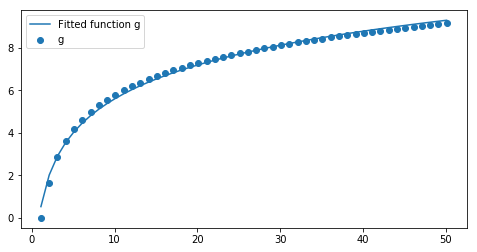

In [481]:
plt.figure(figsize=(8, 4))
plt.scatter(np.array(range(g.size))+1.1, g, label='g')
plt.plot(np.array(range(g.size))+1.1, log_func(np.array(range(g.size))+1.1, params[0], params[1]),
         label='Fitted function g')
plt.legend(loc='best')
plt.show()

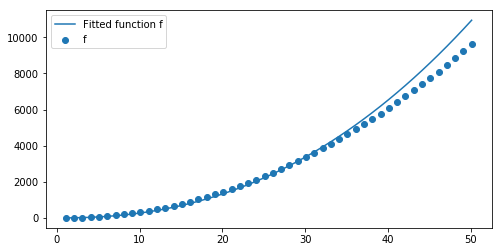

In [482]:
plt.figure(figsize=(8, 4))
plt.scatter(np.array(range(g.size))+1.1, np.transpose(Polynomial_2), label='f')
plt.plot(np.array(range(g.size))+1.1, exp_func(np.array(range(g.size))+1.1, params[0], params[1]),
         label='Fitted function f')
plt.legend(loc='best')
plt.show()

In the $f$ picture we can already see that we should check if the function grows exponetially, since in later values the exponetial function starts to grow much faster.

 We compute the $2$nd and $3$rd derivate of $f$ based on the stencil method [link](http://web.media.mit.edu/~crtaylor/calculator.html)

In [483]:
def df_2(f,h):
    f = np.float64(f)
    h = np.float64(h)
    df = lambda f, h:((45*f[0]-154*f[1]+214*f[2]-156*f[3]+61*f[4]-10*f[5])/(12*1.0*np.power(h,2)))
    return [df(f[j:j+6], 1) for j in range(0,f.size-6)]

df_2(Polynomial_2,100)

[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.
0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 
8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]

In [484]:
def df_3(f,h):
    f = np.float64(f)
    h = np.float64(h)
    df = lambda f, h:((-17*f[0]+71*f[1]-118*f[2]+98*f[3]-41*f[4]+7*f[5])/(4*1.0*np.power(h,3)))
    return [df(f[j:j+6], 1) for j in range(0,f.size-6)]

In [485]:
df_3(Polynomial_2,100)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.
0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

$\mathcal{O}(x^2)$ confirmed.

### Example: $x^{9}+1$

In [486]:
Polynomial_12  = np.asarray([np.power(x,9)+1 for x in range(50)])
dg = np.transpose(d_g(Polynomial_12,100))
X = range(dg.size)
X = sm.add_constant(X)
dg

array([-7.4759333 ,  6.88871961,  4.43439504,  2.98624815,  2.24576562,
        1.79839245,  1.49929662,  1.28537274,  1.12482032,  0.99989926,
        0.8999405 ,  0.81814512,  0.74997653,  0.6922922 ,  0.64284663,
        0.5999927 ,  0.56249482,  0.52940802,  0.49999725,  0.47368216,
        0.44999845,  0.42857024,  0.40908999,  0.39130363,  0.37499943,
        0.35999954,  0.34615348,  0.33333304,  0.32142833,  0.31034463,
        0.29999984,  0.29032244,  0.28124989,  0.27272718,  0.2647058 ,
        0.25714279,  0.24999994,  0.24324319,  0.23684206,  0.23076919,
        0.22499997,  0.21951217,  0.21428569,  0.2093023 ])

In [487]:
sps.spearmanr(range(dg.size),dg)

SpearmanrResult(correlation=-0.8666666666666667, pvalue=2.902552001617057e-14)

We have low p-value so it is a monotonic series. The correlation is negative, so the series is decreasing.
<a id='highPoly'></a>

In [488]:
Result = stat.kpss(dg, regression='c')
(R_scr,pvalue) = Result[0:2]
(R_scr,pvalue) 

(0.3472144503812251, 0.09990756449085124)

In [489]:
Result = stat.adfuller(dg, maxlag=None, regression='c', autolag='AIC')
(R_scr,pvalue) = Result[0:2]
(R_scr,pvalue) 

(-19.084067750858985, 0.0)

The tests suggest that values of the function are stationary. (The final values are already close to $0$, but this is not exactly valid argument since changes in coefficients could streach values of the last value without changing $\mathcal{O}$ )

In [490]:
model = sm.OLS(dg,X)
results = model.fit()
results.params

array([ 1.42462432, -0.03510295])

In [491]:
slope, intercept, r_value, p_value, std_err = sps.linregress(np.array(range(dg.size))+0.0001,dg)
slope, intercept, r_value, p_value

(-0.035102953732727746, 1.4246278254726625, -0.2561180955200621, 0.09332625873
625347)

Negative slope with low p-value, suggest we cannot reject hypothesis that $f$ is not at least exponetial. We will try to show that it is polynomial.

Let try to estimate the highest power of the polynomial.

In [492]:
g = np.transpose(np.log(Polynomial_12))
X = range(g.size)
X = sm.add_constant(X)
g

array([ 0.        ,  0.69314718,  6.24027585,  9.8875614 , 12.47665306,
       14.48494172, 16.12583532, 17.51319137, 18.71497388, 19.7750212 ,
       20.72326584, 21.58105746, 22.36415985, 23.08454422, 23.75151597,
       24.37245181, 24.9532985 , 25.4989201 , 26.01334582, 26.49995081,
       26.96159046, 27.40070194, 27.81938208, 28.21944794, 28.60248447,
       28.96988242, 29.32286884, 29.66253179, 29.98984059, 30.30566247,
       30.61077643, 30.90588484, 31.19162313, 31.46856805, 31.73724472,
       31.99813255, 32.25167045, 32.49826121, 32.73827544, 32.97205482,
       33.19991509, 33.4221486 , 33.63902656, 33.85080104, 34.05770671,
       34.25996241, 34.45777257, 34.65132842, 34.8408091 , 35.02638268])

In [493]:
slope, intercept, r_value, p_value, std_err = \
    sps.linregress(np.log(np.array(range(g.size))+1.1),g)
params=slope, intercept
slope, intercept, r_value, p_value

(9.912647997753384, -3.4880813827104937, 0.9971427111538101, 1.632933102798416
3e-55)

In [494]:
log_linregress(np.array(range(g.size))+1.1,g)

(9.912647997753359, -3.4880813827104205)

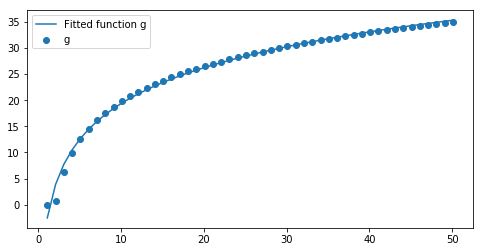

In [495]:
plt.figure(figsize=(8, 4))
plt.scatter(np.array(range(g.size))+1.1, g, label='g')
plt.plot(np.array(range(g.size))+1.1, log_func(np.array(range(g.size))+1.1, params[0], params[1]),
         label='Fitted function g')
plt.legend(loc='best')
plt.show()

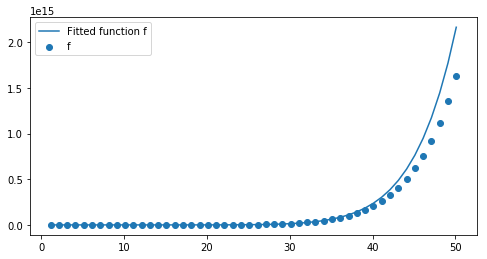

In [496]:
plt.figure(figsize=(8, 4))
plt.scatter(np.array(range(g.size))+1.1, np.transpose(Polynomial_12), label='f')
plt.plot(np.array(range(g.size))+1.1, exp_func(np.array(range(g.size))+1.1, params[0], params[1]),
         label='Fitted function f')

plt.legend(loc='best')
plt.show()

 We compute the $9$th and $10$th derivate of $f$ based on the stencil method [link](http://web.media.mit.edu/~crtaylor/calculator.html)

In [497]:
def df_9(f,h):
    f = np.float64(f)
    h = np.float64(h)
    df = lambda f, h:(-1*f[0]+9*f[1]-36*f[2]+84*f[3]-126*f[4]+126*f[5]-84*f[6]+36*f[7]-9*f[8]+1*f[9])/(1*1.0*np.power(h,9))
    return [df(f[j:j+10], 1) for j in range(0,f.size-10)]

df9 = np.array(df_9(Polynomial_12,100))
df9

array([362880., 362880., 362880., 362880., 362880., 362880., 362880.,
       362880., 362880., 362880., 362880., 362880., 362880., 362880.,
       362880., 362880., 362880., 362880., 362880., 362880., 362880.,
       362880., 362880., 362880., 362880., 362880., 362880., 362880.,
       362880., 362880., 362880., 362880., 362880., 362883., 362879.,
       362881., 362881., 362879., 362883., 362877.])

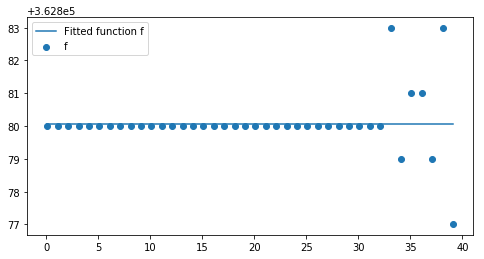

In [498]:
plt.figure(figsize=(8, 4))
plt.scatter(np.array(range(df9.size))+0.1, df9, label='f')
plt.plot(np.array(range(df9.size))+0.1, np.array(np.repeat(np.mean(df9),df9.size)),
         label='Fitted function f')

plt.legend(loc='best')
plt.show()

In [499]:
def df_10(f,h):
    f = np.float64(f)
    h = np.float64(h)
    df = lambda f, h: \
    (1*f[0]-10*f[1]+45*f[2]-120*f[3]+210*f[4]-252*f[5]+210*f[6]-120*f[7]+45*f[8]-10*f[9]+1*f[10])\
    /(1*1.0*np.power(h,10))
    return [df(f[j:j+11], 1) for j in range(0,f.size-11)]

df10 = np.array(df_10(Polynomial_12,100))
df10

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  -2.,   0.,  -7.,
        -4.,  -3.,  -8., -15.,  -2.,   1.])

In [500]:
sc.stats.ttest_1samp(df10, 0)

Ttest_1sampResult(statistic=-2.170312697477995, pvalue=0.036300258703963376)

Quite interesting average doesn't pass a t-test for the mean of $0$.

But when we compare $10$th and $9$th derivate we will get conclusion.

In [501]:
np.linalg.norm(np.divide(df10,df9[:-1]))

5.315050375076482e-05

NOTE: The assumption that we deal with growing function and polynomial is important here. In that case we know that $10$th derivative is $0$, $9$th is constant and $8$th is linear with significant slope (if slope is not significant then $9$th will be close to $0$).

We can just go for polynomial regression and check residuals.

In [502]:
(coef, residuals, rank, singular_values, rcond) = \
np.polyfit(np.array(range(g.size))+1.1, np.transpose(Polynomial_12), 8, full=True)
residuals

array([3.78438246e+21])

In [503]:
(coef, residuals, rank, singular_values, rcond) = \
np.polyfit(np.array(range(g.size))+1.1, np.transpose(Polynomial_12), 10, full=True)
residuals

array([0.09337854])

In [504]:
(coef, residuals, rank, singular_values, rcond) = \
np.polyfit(np.array(range(g.size))+1.1, np.transpose(Polynomial_12), 9, full=True)
residuals

array([0.17609507])

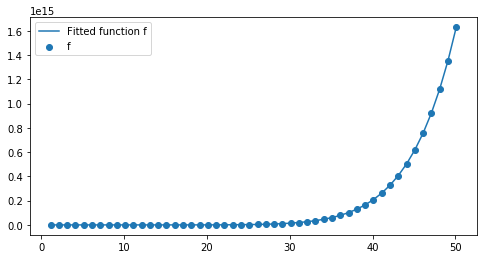

In [505]:
plt.figure(figsize=(8, 4))
plt.scatter(np.array(range(g.size))+1.1, np.transpose(Polynomial_12), label='f')
plt.plot(np.array(range(g.size))+1.1, np.polyval(coef, np.array(range(g.size))+1.1),
         label='Fitted function f')

plt.legend(loc='best')
plt.show()

So polynomial with degree $9$ fits not much worse than with degree $10$, but degree $8$ is not enough.

Two time the same conclusion, should be ok.

#### Lets try add a little errors, since we obviously will get them in a product environment.

### Example: $e^x+1$ with added error

In [506]:
Exponential_2 = np.asarray([np.exp(x)+1 for x in range(50)])
Exponential_2 = Exponential_2 + 0.05 * np.random.normal(size=Exponential_2.size)
dg = np.transpose(d_g(Exponential_2,100))
X = range(dg.size)
X = sm.add_constant(X)
dg


array([0.4290692 , 0.75978721, 0.86255573, 0.95385649, 0.98503094,
       0.9925841 , 0.99776118, 0.99911028, 0.99969348, 0.9998935 ,
       0.99995155, 0.99998389, 0.99999394, 0.99999755, 0.99999926,
       0.99999978, 0.99999984, 0.99999998, 0.99999998, 0.99999999,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [507]:
sps.spearmanr(range(dg.size),dg)

SpearmanrResult(correlation=0.9913654818079233, pvalue=1.082667291052979e-38)

The same situation as in the example [without error](#eXplus1). So $f$ grows at least exponetially.

In [508]:
Result = stat.kpss(dg, regression='c')
(R_scr,pvalue) = Result[0:2]
(R_scr,pvalue) 

(0.3532141588701037, 0.09732148324564495)

In [509]:
Result = stat.adfuller(dg, maxlag=None, regression='c', autolag='AIC')
(R_scr,pvalue) = Result[0:2]
(R_scr,pvalue) 

(-10.456456427513379, 1.394589188147616e-18)

What is very interesting, for me adding normal errors made augmented Dickey–Fuller test to work. We can now state that the series is stationary.

Lets check linear regresion then, we want to know intercept:

In [510]:
model = sm.OLS(dg,X)
results = model.fit()
results.params

array([0.91264579, 0.00298399])

In [511]:
slope, intercept, r_value, p_value, std_err = sps.linregress(range(dg.size),dg)
slope, intercept, r_value, p_value

(0.00298398845120085, 0.9126457910025061, 0.4070480693810221, 0.00610327974032
2941)

Intercept above $0$, the p-value is way below $0.05$. So $f$ grows at least exponetially.

### Example: $x^{9}+1$ with added error

In [537]:
Polynomial_12  = np.asarray([np.power(x,9)+1 for x in range(50)])
Polynomial_12 = Polynomial_12 + 0.05 * np.random.normal(size=Polynomial_12.size)
dg = np.transpose(d_g(Polynomial_12,100))
X = range(dg.size)
X = sm.add_constant(X)
dg

array([-7.46551672,  6.83127237,  4.43417132,  2.98624775,  2.24576597,
        1.79839247,  1.49929663,  1.28537274,  1.12482032,  0.99989926,
        0.8999405 ,  0.81814512,  0.74997653,  0.6922922 ,  0.64284663,
        0.5999927 ,  0.56249482,  0.52940802,  0.49999725,  0.47368216,
        0.44999845,  0.42857024,  0.40908999,  0.39130363,  0.37499943,
        0.35999954,  0.34615348,  0.33333304,  0.32142833,  0.31034463,
        0.29999984,  0.29032244,  0.28124989,  0.27272718,  0.2647058 ,
        0.25714279,  0.24999994,  0.24324319,  0.23684206,  0.23076919,
        0.22499997,  0.21951217,  0.21428569,  0.2093023 ])

In [538]:
sps.spearmanr(range(dg.size),dg)

SpearmanrResult(correlation=-0.8666666666666667, pvalue=2.902552001617057e-14)

As in not error [case](#highPoly). We have low p-value so it is a monotonic series. The correlation is negative, so series is decreasing.

In [539]:
import warnings
warnings.filterwarnings('ignore')
Result = stat.kpss(dg, regression='c')
warnings.filterwarnings('always')     

(R_scr,pvalue) = Result[0:2]
(R_scr,pvalue) 

(0.3467492004284499, 0.1)

In [540]:
Result = stat.adfuller(dg, maxlag=None, regression='c', autolag='AIC')
(R_scr,pvalue) = Result[0:2]
(R_scr,pvalue) 

(-2.422194578746561, 0.13556988366396738)

Hard to get conclusions here, p-value changes from run to run for me.

In [541]:
model = sm.OLS(dg,X)
results = model.fit()
results.params

array([ 1.42064709, -0.03496792])

In [517]:
slope, intercept, r_value, p_value, std_err = sps.linregress(np.array(range(dg.size))+0.0001,dg)
slope, intercept, r_value, p_value

(-0.03469060667894917, 1.4127416385735165, -0.24924172278106593, 0.10277410586
437825)

Negative slope with low p-value (not always). We cannot reject hypothesis that growth $f$ is not at least exponetial anyway. We will try to show that it is polynomial.

Let try to estimate the highest power of the polynomial.

In [542]:
g = np.transpose(np.log(Polynomial_12))
X = range(g.size)
X = sm.add_constant(X)
g

array([ 0.05078685,  0.71852118,  6.24037378,  9.88756122, 12.47665289,
       14.48494171, 16.12583532, 17.51319137, 18.71497388, 19.7750212 ,
       20.72326584, 21.58105746, 22.36415985, 23.08454422, 23.75151597,
       24.37245181, 24.9532985 , 25.4989201 , 26.01334582, 26.49995081,
       26.96159046, 27.40070194, 27.81938208, 28.21944794, 28.60248447,
       28.96988242, 29.32286884, 29.66253179, 29.98984059, 30.30566247,
       30.61077643, 30.90588484, 31.19162313, 31.46856805, 31.73724472,
       31.99813255, 32.25167045, 32.49826121, 32.73827544, 32.97205482,
       33.19991509, 33.4221486 , 33.63902656, 33.85080104, 34.05770671,
       34.25996241, 34.45777257, 34.65132842, 34.8408091 , 35.02638268])

In [543]:
slope, intercept, r_value, p_value, std_err = \
    sps.linregress(np.log(np.array(range(g.size))+1.1),g)
params=slope, intercept
slope, intercept, r_value, p_value

(9.907245479214732, -3.470465360058583, 0.9971263227751939, 1.872845174520271e
-55)

In [544]:
log_linregress(np.array(range(g.size))+1.1,g)

(9.90724547921472, -3.4704653600585518)

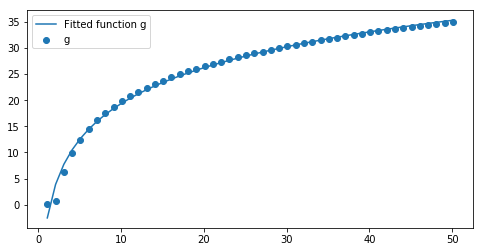

In [545]:
plt.figure(figsize=(8, 4))
plt.scatter(np.array(range(g.size))+1.1, g, label='g')
plt.plot(np.array(range(g.size))+1.1, log_func(np.array(range(g.size))+1.1, params[0], params[1]),
         label='Fitted function g')
plt.legend(loc='best')
plt.show()

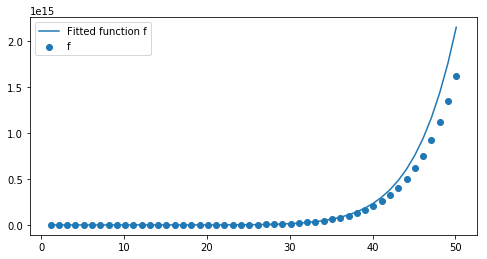

In [546]:
plt.figure(figsize=(8, 4))
plt.scatter(np.array(range(g.size))+1.1, np.transpose(Polynomial_12), label='f')
plt.plot(np.array(range(g.size))+1.1, exp_func(np.array(range(g.size))+1.1, params[0], params[1]),
         label='Fitted function f')
plt.legend(loc='best')
plt.show()

 We compute the $9$th and $10$th derivate of $f$ based on the stencil method [link](http://web.media.mit.edu/~crtaylor/calculator.html)

In [547]:
df9 = np.array(df_9(Polynomial_12,100))
df9

array([362884.03323436, 362873.21552289, 362888.84989023, 362872.77772999,
       362879.71331596, 362891.30451965, 362859.1772995 , 362905.73442078,
       362853.80107117, 362904.30599976, 362857.95404053, 362899.39562988,
       362864.85595703, 362889.85913086, 362873.88769531, 362886.33251953,
       362868.875     , 362897.60839844, 362860.0078125 , 362895.30859375,
       362872.96484375, 362879.95703125, 362885.71484375, 362868.34375   ,
       362895.421875  , 362866.078125  , 362889.890625  , 362872.078125  ,
       362887.921875  , 362873.46875   , 362887.25      , 362870.90625   ,
       362893.0625    , 362864.4375    , 362897.5       , 362858.875     ,
       362902.        , 362859.        , 362906.875     , 362863.        ])

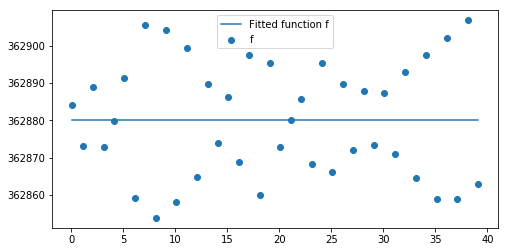

In [548]:
plt.figure(figsize=(8, 4))
plt.scatter(np.array(range(df9.size))+0.1, df9, label='f')
plt.plot(np.array(range(df9.size))+0.1, np.array(np.repeat(np.mean(df9),df9.size)),
         label='Fitted function f')
plt.legend(loc='best')
plt.show()

In [549]:
def df_10(f,h):
    f = np.float64(f)
    h = np.float64(h)
    df = lambda f, h: \
    (1*f[0]-10*f[1]+45*f[2]-120*f[3]+210*f[4]-252*f[5]+210*f[6]-120*f[7]+45*f[8]-10*f[9]+1*f[10])\
    /(1*1.0*np.power(h,10))
    return [df(f[j:j+11], 1) for j in range(0,f.size-11)]

df10 = np.array(df_10(Polynomial_12,100))
df10

array([-10.81771076,  15.63436937, -16.07215786,   6.93557549,
        11.59121704, -32.12723541,  46.55717468, -51.93305969,
        50.50521851, -46.35089111,  41.4395752 , -34.53759766,
        25.0065918 , -15.96777344,  12.42626953, -17.44140625,
        28.74121094, -37.5625    ,  35.33203125, -22.41015625,
         6.83203125,   5.74609375, -17.28125   ,  27.109375  ,
       -29.171875  ,  23.203125  , -17.546875  ,  15.546875  ,
       -14.53125   ,  13.25      , -17.09375   ,  21.0625    ,
       -31.5625    ,  30.5       , -43.125     ,  49.        ,
       -51.        ,  53.875     , -61.        ])

In [550]:
sc.stats.ttest_1samp(df10, 0)

Ttest_1sampResult(statistic=-0.23562112670063887, pvalue=0.8149919538332951)

Higher variance help statistical tests to get conclusions about the mean. Still it is not significant.

But when we compare $10$th and $9$th derivate we will get conclusion.

In [551]:
np.linalg.norm(np.divide(df10,df9[:-1]))

0.0005457521021343983

Do the polynomial regression and check residuals.

In [552]:
(coef, residuals, rank, singular_values, rcond) = \
np.polyfit(np.array(range(g.size))+1.1, np.transpose(Polynomial_12), 8, full=True)
residuals

array([3.78438246e+21])

In [553]:
(coef, residuals, rank, singular_values, rcond) = \
np.polyfit(np.array(range(g.size))+1.1, np.transpose(Polynomial_12), 10, full=True)
residuals

array([0.2180481])

In [554]:
(coef, residuals, rank, singular_values, rcond) = \
np.polyfit(np.array(range(g.size))+1.1, np.transpose(Polynomial_12), 9, full=True)
residuals

array([0.24998409])

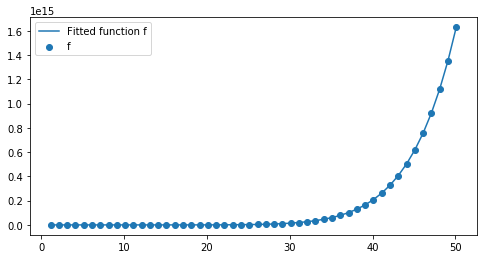

In [555]:
plt.figure(figsize=(8, 4))
plt.scatter(np.array(range(g.size))+1.1, np.transpose(Polynomial_12), label='f')
plt.plot(np.array(range(g.size))+1.1, np.polyval(coef, np.array(range(g.size))+1.1),
         label='Fitted function f')

plt.legend(loc='best')
plt.show()

The degree is $9$. It looks that everything works.

## Q.E.D$_\square$

 ### Bibliography & references:

http://web.media.mit.edu/~crtaylor/calculator.html

https://www.statsmodels.org

https://docs.scipy.org

https://stats.stackexchange.com/questions/30569/what-is-the-difference-between-a-stationary-test-and-a-unit-root-test/235916

https://scipy-cookbook.readthedocs.io/items/FittingData.html

http://cars9.uchicago.edu/software/python/lmfit/lmfit.pdf

https://docs.sympy.org

https://www.southampton.ac.uk/~fangohr/teaching/python/book/html/12-symbolic-computation.html

https://www.coursera.org/learn/machine-learning/lecture/2DKxQ/normal-equation

A lot of https://en.wikipedia.org/

https://foothill.edu/psme/daley/tutorials_files/10.%20Error%20Propagation.pdf

https://sites.fas.harvard.edu/~scphys/nsta/error_propagation.pdf

http://ipl.physics.harvard.edu/wp-uploads/2013/03/PS3_Error_Propagation_sp13.pdf

http://se.mathworks.com/help/econ/kpsstest.html

which references:

Hamilton, J. D. Time Series Analysis. Princeton, NJ: Princeton University Press, 1994.

Kwiatkowski, D., P. C. B. Phillips, P. Schmidt, and Y. Shin. “Testing the Null Hypothesis of Stationarity against the Alternative of a Unit Root.” Journal of Econometrics. Vol. 54, 1992, pp. 159–178.

Newey, W. K., and K. D. West. “A Simple, Positive Semidefinite, Heteroskedasticity and Autocorrelation Consistent Covariance Matrix.” Econometrica. Vol. 55, 1987, pp. 703–708. 

https://en.wikipedia.org/wiki/Isotonic_regression

http://scikit-learn.org/stable/modules/generated/sklearn.isotonic.IsotonicRegression.html#sklearn.isotonic.IsotonicRegression